In [1]:
%load_ext autoreload 
%autoreload 2
import os, sys
import time, math
import argparse, random
from math import exp
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as tfs
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as FF
import torchvision.utils as vutils
from torchvision.utils import make_grid
from torchvision.models import vgg16

from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from utils import *
from ffa_net import *
import cv2
from utils import get_video
# import sys
# from PIL import Image
# from matplotlib import pyplot as plt
# import numpy as np

In [2]:
_MODEL_PATH = '../../model/its_train_ffa_3_12.pth'
# _VID_PATH = '../../data/countryside.mp4'
# _VID_PATH = '../../data/skyland_10s.mp4'
_IMG_PATH = '../../data/test_gen_haze_1.jpg'

In [3]:
img = cv2.imread(_IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
# get_video(_VID_PATH)

In [5]:
# vid_capture = cv2.VideoCapture(_VID_PATH)
# while(vid_capture.isOpened()):
#     ret, frame = vid_capture.read()
#     break
#     if ret == False:
#         break

# vid_capture.release()
# cv2.destroyAllWindows()

In [6]:
img.shape

(460, 620, 3)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
def load_checkpoint(filepath):
    if torch.cuda.is_available():
        checkpoint = torch.load(filepath)
    else:
        checkpoint = torch.load(filepath,map_location=torch.device('cpu'))
    model = FFA(gps=3, blocks=12)
    model = nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [9]:
model = load_checkpoint(_MODEL_PATH)

In [10]:
fw_transform = tfs.Compose([
        # tfs.Resize(460),
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])])

In [11]:
img.shape

(460, 620, 3)

In [12]:
img_haze = Image.fromarray(img)
img_haze = fw_transform(img_haze)[None,::]

In [13]:
img_haze.shape

torch.Size([1, 3, 460, 620])

In [14]:
with torch.no_grad():
    pred = model(img_haze)

In [15]:
ts = torch.squeeze(pred.clamp(0,1).cpu())    
# ts = make_grid(ts, nrow=1, normalize=True)

In [16]:
ts.min()

tensor(0.)

In [17]:
img_dehaze = ts.numpy()
img_dehaze = np.moveaxis(img_dehaze, 0,-1)
img_dehaze.shape

(460, 620, 3)

In [19]:
# plt.imshow(frame)

In [20]:
img_dehaze = (img_dehaze * 255).astype('uint8')

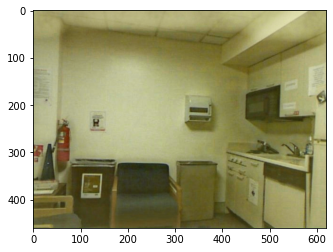

In [21]:
plt.imshow(img_dehaze)

In [23]:
# img_dehaze